In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:


df = pd.read_parquet("hf://datasets/tabilab/biosses/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# EDA

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [94]:
df_low = df[df['score'] <= 1.5]
df_high = df[df['score'] >= 2.5]
df_middle = df[(df['score'] > 1.5) & (df['score'] < 2.5)]

In [28]:
print("All pairs: ", len(df))
print("Low score pairs: ", len(df_low))
print("Middle score pairs: ", len(df_middle))
print("High score pairs: ", len(df_high))

All pairs:  100
Low score pairs:  26
Middle score pairs:  28
High score pairs:  46


In [35]:
print(df['sentence1'][0])
print('\n')
print(df['sentence2'][0])

Here, looking for agents that could specifically kill KRAS mutant cells, they found that knockdown of GATA2 was synthetically lethal with KRAS mutation


Not surprisingly, GATA2 knockdown in KRAS mutant cells resulted in a striking reduction of active GTP-bound RHO proteins, including the downstream ROCK kinase


In [65]:
all_sentences = pd.concat([df['sentence1'], df['sentence2']]).reset_index(name='sentence')

In [68]:
all_sentences['char_len'] = all_sentences['sentence'].str.len()

In [88]:
all_sentences['word_count'] = all_sentences['sentence'].map(lambda sentence: len(sentence.split()))

In [78]:
def average_word_len(sentence):
  words = sentence.split()
  return np.mean(list(map(lambda word: len(word), words)))

In [87]:
all_sentences['average_word_len'] = all_sentences['sentence'].map(average_word_len)

In [90]:
all_sentences.head()

,index,sentence,char_len,word_count,average_word_len
0,0,"Here, looking for agents that could specifical...",151,23,5.608696
1,1,MLL-FKBP and MLL-AF9 transformed cells showed ...,124,22,4.681818
2,2,The oncogenic activity of mutant Kras appears ...,75,11,5.909091
3,3,Consequently miRNAs have been demonstrated to ...,172,24,6.208333
4,4,We then sought to reassess the regulation of m...,121,20,5.100000


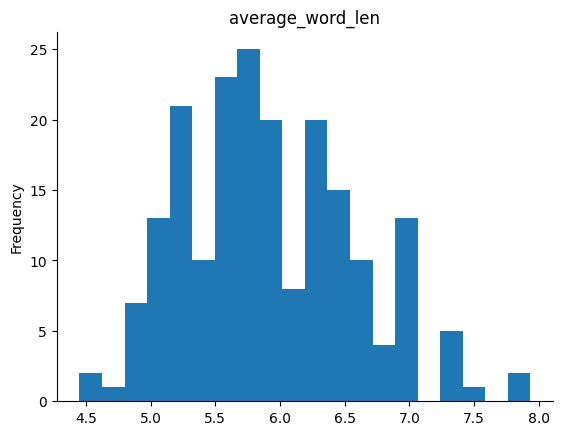

In [100]:
from matplotlib import pyplot as plt
all_sentences['average_word_len'].plot(kind='hist', bins=20, title='average_word_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

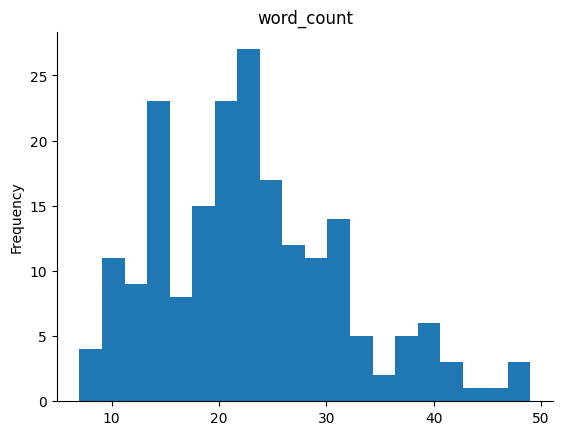

In [105]:
from matplotlib import pyplot as plt
all_sentences['word_count'].plot(kind='hist', bins=20, title='word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

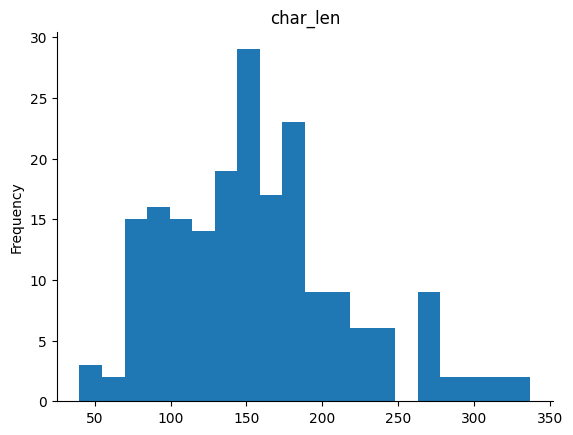

In [97]:
from matplotlib import pyplot as plt
all_sentences['char_len'].plot(kind='hist', bins=20, title='char_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [112]:
def preprocess_sentence(sentence):
  lowered = sentence.lower()
  filtered = re.sub('[^\w\s\d]+', '', lowered)
  no_stop = " ".join([word for word in filtered.split() if word not in stopwords.words('english')])
  return no_stop

In [115]:
print(all_sentences['sentence'][0])

print(preprocess_sentence(all_sentences['sentence'][0]))

Here, looking for agents that could specifically kill KRAS mutant cells, they found that knockdown of GATA2 was synthetically lethal with KRAS mutation
looking agents could specifically kill kras mutant cells found knockdown gata2 synthetically lethal kras mutation


In [124]:
word_count_dict = {}
for sentence in all_sentences['sentence']:
  for word in preprocess_sentence(sentence).split():
    if word_count_dict.get(word) is not None:
      word_count_dict.update({word: word_count_dict.get(word) + 1})
    else:
      word_count_dict.update({word: 1})


In [136]:
most_popular = sorted(word_count_dict.items(), key = lambda pair: pair[1], reverse=True)[:10]
print(most_popular)

[('cells', 44), ('expression', 39), ('cell', 38), ('cancer', 38), ('tumor', 26), ('human', 20), ('genes', 19), ('kras', 18), ('activity', 18), ('recently', 18)]


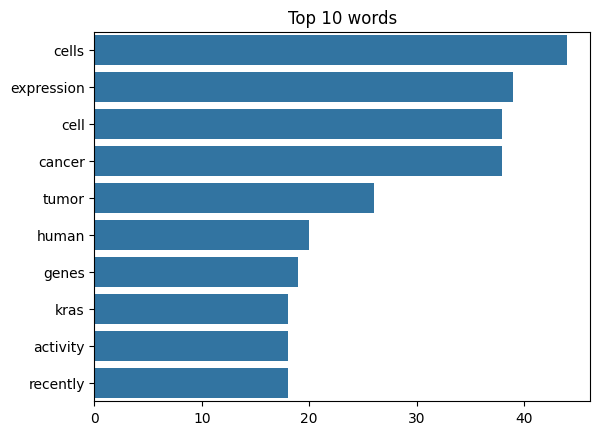

In [137]:
keys = []
freq = []
for word, count in most_popular:
    keys.append(word)
    freq.append(count)

sns.barplot(x=freq, y=keys)
plt.title('Top 10 words')
plt.show()


